In [2]:
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt 
%matplotlib inline
import pandas as pd
from datetime import date, timedelta
from pandas import DataFrame
import sqlalchemy as sq
import pickle
import numpy as np 
import math
import time
import scipy as scipy
from scipy import stats
import seaborn as sns
from sklearn import linear_model, metrics, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold,train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn import svm
from ggplot import *
import statsmodels.api as sm
import xgboost as xgb
from xgboost import XGBRegressor
from modelselector import EstimatorSelectionHelper
import multiprocessing
import warnings
warnings.filterwarnings('ignore')

import gc

/usr/lib64/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
data=pd.read_csv('/data/pratik/tensor/ad_clean_year.csv',error_bad_lines=False)
#data2=pd.read_csv('/data/pratik/tensor/sessions.csv',error_bad_lines=False)
#data=data1.merge(data2,how='left',on='date')

In [3]:
data['bag_id']=data['brand']+data['article_type']+data['gender']
data['ros_lag']=data.groupby(['bag_id'])['qty_sold'].shift(1)
data['ros_rm']=data.groupby(['bag_id'])['ros_lag'].rolling(15, min_periods=1).mean().reset_index(0,drop=True)
data['op_td_lag']=data.groupby(['bag_id'])['output_td'].shift(1)
data['output_td_rm']=data.groupby(['bag_id'])['op_td_lag'].rolling(15, min_periods=1).mean().reset_index(0,drop=True)
data['ip_td_lag']=data.groupby(['bag_id'])['input_td'].shift(1)
data['input_td_rm']=data.groupby(['bag_id'])['ip_td_lag'].rolling(15, min_periods=1).mean().reset_index(0,drop=True)
data['input_td_diff']=data['input_td']/data['input_td_rm']
data['output_td_diff']=data['output_td']/data['output_td_rm']
data['presale_flag']=0
data.loc[data['date'].isin([20170125,20170407,20170513,20160701,20161001,20161021]),'presale_flag']=1
data.fillna(0,inplace=True)

In [ ]:
data['input_td_wgt']=

In [15]:
data.head()

date         brand        article_type gender  qty_sold  live_styles  \
0  20170519   Metersbonwe           Waistcoat  Women         0            1   
1  20170616         Inc 5        Casual Shoes  Women         1            9   
2  20160805  Jack & Jones            Sweaters    Men        42           52   
3  20170419         GUESS  Fragrance Gift Set    Men         0            1   
4  20160714  Jack & Jones            Trousers    Men        88          125   

   list_count  inventory   input_td  output_td    ...      \
0         306          8  40.000000   0.000000    ...       
1        5447   17999940  31.666667   0.500000    ...       
2       25497        435  60.000000   0.600000    ...       
3          86         16  12.000000   0.000000    ...       
4      196477       1798  51.040000   0.584866    ...       

                       bag_id  input_td_rm  input_td_diff  output_td_rm  \
0   MetersbonweWaistcoatWomen          0.0            0.0           0.0   
1      Inc 5Casual ShoesWomen          0.0            0.0           0.0   
2     Jack & JonesSweatersMen          0.0            0.0           0.0   
3  GUESSFragrance Gift SetMen          0.0            0.0           0.0   
4     Jack & JonesTrousersMen          0.0            0.0           0.0   

   output_td_diff  presale_flag  ros_lag ros_rm  op_td_lag  ip_td_lag  
0             0.0             0      0.0    0.0        0.0        0.0  
1             0.0             0      0.0    0.0        0.0        0.0  
2             0.0             0      0.0    0.0        0.0        0.0  
3             0.0             0      0.0    0.0        0.0        0.0  
4             0.0             0      0.0    0.0        0.0        0.0  

[5 rows x 27 columns]

In [4]:
bag_summary=data.groupby(['brand','article_type','gender']).agg({'qty_sold' : np.sum})
bag_summary.reset_index(inplace=True)
bag_summary.sort_values(by='qty_sold',ascending=False).head(n=10)

brand  article_type gender  qty_sold
14748     Roadster       Tshirts    Men   1113640
14729     Roadster        Shirts    Men    600587
11473  Moda Rapido       Tshirts    Men    300066
14697     Roadster  Casual Shoes    Men    297391
1459         Anouk        Kurtas  Women    282052
18945            W        Kurtas  Women    259934
14712     Roadster         Jeans    Men    254725
10018        Libas        Kurtas  Women    251540
299            AKS        Kurtas  Women    201153
5724    FOREVER 21          Tops  Women    174631

In [5]:
def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true,y_pred))) * 100

In [6]:
def get_best_model(lst):
    b=lst[0]
    a=lst[1]
    g=lst[2]
    ad=data[(data['brand']==b) & (data['article_type']==a) & (data['gender']==g) ]

    ad.sort_values(by='date',inplace=True)
    
    d=ad[['date','qty_sold','input_td','input_td_diff','lc_share_pltf','live_styles','presale_flag','sessions','brokeness','freshness']]

    train, test= train_test_split(d, test_size=0.2, random_state=0)
    y_train = train.qty_sold
    X_train = train.drop(['qty_sold','date'],axis=1)

    y_test = test.qty_sold
    X_test = test.drop(['qty_sold','date'],axis=1)

    models1 = { 
        'LinearRegression': LinearRegression(),
        'RandomForestRegressor': RandomForestRegressor(),
        'GradientBoostingRegressor': GradientBoostingRegressor(),
        'XGBRegressor': XGBRegressor()
    }

    params1 = { 
        'LinearRegression': { },
        'RandomForestRegressor': { 'n_estimators':[50,100,200],'max_depth':[4,5,6,7] },
        'GradientBoostingRegressor':  { 'n_estimators':[50,100,200],'max_depth':[4,5,6,7] ,'random_state':[0]},
        'XGBRegressor': { 'booster':['gbtree', 'gblinear'] }
    }

    mape_scorer=make_scorer(mape,greater_is_better=False)
    selection= EstimatorSelectionHelper(models1, params1)
    selection.fit(X_train,y_train, cv=10, n_jobs=-1,scoring=mape_scorer)
    gs_eval=selection.score_summary()
    gs_eval.reset_index(inplace=True)
    gs_eval.drop('index',axis=1,inplace=True)
    best_est=gs_eval.loc[0,'estimator']
    gs_eval

    filename=b+'-'+a+'-'+g
    test_est=selection.grid_searches[best_est].best_estimator_
    mp=mape(test_est.predict(X_test), y_test)
    print( 'Validation MAPE: %0.2f' %mp) 
    pred=pd.concat([test.date.reset_index(),y_test.reset_index(),pd.DataFrame(test_est.predict(X_test),columns=['pred'])], axis=1)
    pred['ape']=np.abs((pred['pred'] - pred['qty_sold']) / np.maximum(pred['qty_sold'],pred['pred']))
    pred['ae']=(pred['pred'] - pred['qty_sold']) /  np.maximum(pred['qty_sold'],pred['pred'])
    pred['bag']=filename
    pred.to_csv('/data/pratik/tensor/validations/nonlinear_validations/'+filename+'.csv',index=False)
    with open('/data/pratik/tensor/tmp/'+filename+'.pkl', 'wb') as f:
                    pickle.dump(test_est, f)
    ret=pd.DataFrame({ 'Brand': b,'Article_type': a,'Gender':g,'mape':mp}, index=[filename])
    print b+a+g+': completed'
    return ret

In [7]:
#lst=bag_summary.sort_values(by='qty_sold',ascending=False).drop('qty_sold',axis=1).head(n=1000).to_records(index=False).tolist()
p = multiprocessing.Pool(10);

Running GridSearchCV for GradientBoostingRegressor.
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for GradientBoostingRegressor.
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of

[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.8s finished
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.8s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.7s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    8.5s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.6s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.5s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.0s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   11.1s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   12.2s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   56.8s finished
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   58.2s finished
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   58.3s finished
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   58.3s finished


Validation MAPE: 13.73
FOREVER 21TopsWomen: completed
Validation MAPE: 19.42
Validation MAPE: 13.15
LibasKurtasWomen: completed
Validation MAPE: 15.63
AnoukKurtasWomen: completed
Moda RapidoTshirtsMen: completed
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   58.2s finished
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   57.3s finished


Validation MAPE: 15.52
AKSKurtasWomen: completed
Validation MAPE: 14.19
RoadsterShirtsMen: completed
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.8s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    9.1s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.5s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.0s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.7s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    8.6s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.4min finished


Validation MAPE: 15.33
RoadsterTshirtsMen: completed


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.4min finished


Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Validation MAPE: 13.94
RoadsterCasual ShoesMen: completed


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.4min finished


Validation MAPE: 15.49
RoadsterJeansMen: completed
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.5min finished


Validation MAPE: 16.76
WKurtasWomen: completed


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    8.5s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    7.8s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits
Running GridSearchCV for GradientBoostingRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.4s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   10.6s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.7s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   13.5s finished


Running GridSearchCV for LinearRegression.
Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.1s finished


Running GridSearchCV for XGBRegressor.
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    0.6s finished


Running GridSearchCV for RandomForestRegressor.
Fitting 10 folds for each of 12 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   57.3s finished


Validation MAPE: 18.16
VishudhKurtasWomen: completed


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.0min finished


Validation MAPE: 18.21
BibaKurtasWomen: completed


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished


Validation MAPE: 18.06
HRX by Hrithik RoshanTshirtsMen: completed


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished


Validation MAPE: 15.47
HIGHLANDERShirtsMen: completed
Validation MAPE: 14.76
RoadsterTopsWomen: completed


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.3min finished


Validation MAPE: 16.19
HarpaTopsWomen: completed


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   58.1s finished


Validation MAPE: 17.87
United Colors of BenettonTshirtsMen: completed


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.2min finished


Validation MAPE: 17.99
John PlayersShirtsMen: completed


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.2min finished


Validation MAPE: 15.96
etherTshirtsMen: completed


[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.1min finished


Validation MAPE: 19.73
Jack & JonesTshirtsMen: completed


In [8]:
lst=bag_summary.sort_values(by='qty_sold',ascending=False).drop('qty_sold',axis=1).head(n=20).to_records(index=False).tolist()

In [9]:
len(lst)

20

In [10]:
fit_data=p.map(get_best_model, lst);

In [12]:
final = pd.concat(fit_data)

In [13]:
final

Article_type  \
Roadster-Tshirts-Men                        Tshirts   
Roadster-Shirts-Men                          Shirts   
Moda Rapido-Tshirts-Men                     Tshirts   
Roadster-Casual Shoes-Men              Casual Shoes   
Anouk-Kurtas-Women                           Kurtas   
W-Kurtas-Women                               Kurtas   
Roadster-Jeans-Men                            Jeans   
Libas-Kurtas-Women                           Kurtas   
AKS-Kurtas-Women                             Kurtas   
FOREVER 21-Tops-Women                          Tops   
HIGHLANDER-Shirts-Men                        Shirts   
Roadster-Tops-Women                            Tops   
Biba-Kurtas-Women                            Kurtas   
HRX by Hrithik Roshan-Tshirts-Men           Tshirts   
Vishudh-Kurtas-Women                         Kurtas   
Harpa-Tops-Women                               Tops   
John Players-Shirts-Men                      Shirts   
ether-Tshirts-Men                           Tshirts   
United Colors of Benetton-Tshirts-Men       Tshirts   
Jack & Jones-Tshirts-Men                    Tshirts   

                                                           Brand Gender  \
Roadster-Tshirts-Men                                    Roadster    Men   
Roadster-Shirts-Men                                     Roadster    Men   
Moda Rapido-Tshirts-Men                              Moda Rapido    Men   
Roadster-Casual Shoes-Men                               Roadster    Men   
Anouk-Kurtas-Women                                         Anouk  Women   
W-Kurtas-Women                                                 W  Women   
Roadster-Jeans-Men                                      Roadster    Men   
Libas-Kurtas-Women                                         Libas  Women   
AKS-Kurtas-Women                                             AKS  Women   
FOREVER 21-Tops-Women                                 FOREVER 21  Women   
HIGHLANDER-Shirts-Men                                 HIGHLANDER    Men   
Roadster-Tops-Women                                     Roadster  Women   
Biba-Kurtas-Women                                           Biba  Women   
HRX by Hrithik Roshan-Tshirts-Men          HRX by Hrithik Roshan    Men   
Vishudh-Kurtas-Women                                     Vishudh  Women   
Harpa-Tops-Women                                           Harpa  Women   
John Players-Shirts-Men                             John Players    Men   
ether-Tshirts-Men                                          ether    Men   
United Colors of Benetton-Tshirts-Men  United Colors of Benetton    Men   
Jack & Jones-Tshirts-Men                            Jack & Jones    Men   

                                            mape  
Roadster-Tshirts-Men                   15.328976  
Roadster-Shirts-Men                    14.186389  
Moda Rapido-Tshirts-Men                13.149364  
Roadster-Casual Shoes-Men              13.942494  
Anouk-Kurtas-Women                     15.628040  
W-Kurtas-Women                         16.764012  
Roadster-Jeans-Men                     15.486713  
Libas-Kurtas-Women                     19.416170  
AKS-Kurtas-Women                       15.516133  
FOREVER 21-Tops-Women                  13.727054  
HIGHLANDER-Shirts-Men                  15.474412  
Roadster-Tops-Women                    14.756506  
Biba-Kurtas-Women                      18.205678  
HRX by Hrithik Roshan-Tshirts-Men      18.055043  
Vishudh-Kurtas-Women                   18.157830  
Harpa-Tops-Women                       16.189071  
John Players-Shirts-Men                17.989046  
ether-Tshirts-Men                      15.959435  
United Colors of Benetton-Tshirts-Men  17.874378  
Jack & Jones-Tshirts-Men               19.728703

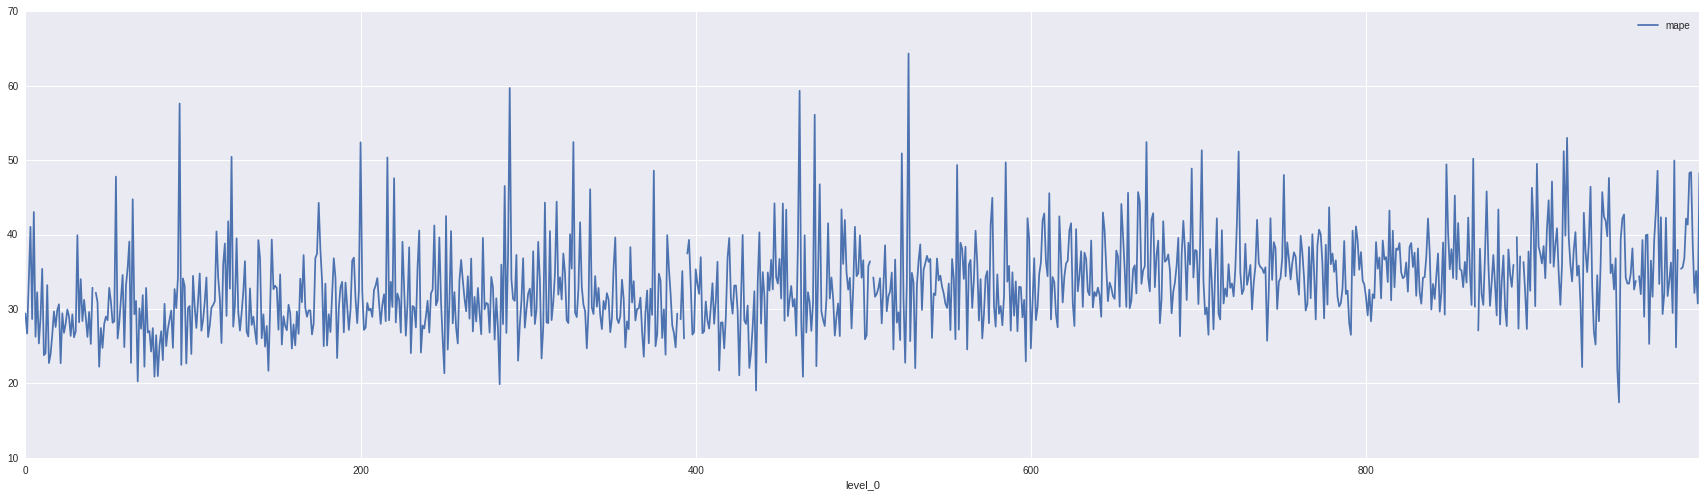

In [13]:
mp=final.reset_index().reset_index()
bag_mape=mp[['level_0','mape']]
#bag_mape[bag_mape['mape']<100].plot(0,figsize=(30, 8))
bag_mape.plot(0,figsize=(30, 8))

In [6]:
def get_overall_mape(lst):
    b=lst[0]
    a=lst[1]
    g=lst[2] 
    filename=b+'-'+a+'-'+g
    pred=pd.read_csv('/data/pratik/tensor/validations/'+filename+'.csv',error_bad_lines=False)
    return pred

In [7]:
new_lst=bag_summary.sort_values(by='qty_sold',ascending=False).drop('qty_sold',axis=1).head(n=2000).to_records(index=False).tolist()
p = multiprocessing.Pool(10)
ovr_mape_data=p.map(get_overall_mape, new_lst)
ovr_data = pd.concat(ovr_mape_data)

In [11]:
a=ovr_data.groupby('date')['qty_sold','pred'].sum()
a.reset_index(inplace=True)
a[a['date']==20170424]

date  qty_sold          pred
304  20170424     73673  73645.690252

In [12]:
ovr_data.groupby('date')['qty_sold','pred'].sum().to_csv('mape.csv')

In [ ]:
bag_mape[['mape']].describe(percentiles=[.01,.05,.1,.15,.2,.3,.4,.5,.6,.7,.8,.9,.95,.97,.99]).transpose()

In [5]:
final=pd.read_csv('/data/pratik/tensor/summary/models_summary_new_mape2.csv',error_bad_lines=False)
final.head()

Article_type          Brand Gender       mape
0       Shirts         Turtle    Men  29.386813
1  Night suits         Kanvin  Women  26.696020
2     Palazzos        Varanga  Women  33.982288
3  Track Pants   John Players    Men  41.045135
4     Trousers  all about you  Women  28.644620

In [6]:
final[['mape']].describe(percentiles=[.01,.05,.1,.15,.2,.3,.4,.5,.6,.7,.8,.9,.95,.97,.99]).transpose()

count  mean  std        min         1%         5%        10%  \
mape  1000.0   inf  NaN  17.448332  21.738587  24.840649  26.605014   

            15%       20%        30%        40%        50%        60%  \
mape  27.442692  28.21175  29.933622  31.235333  32.738311  34.165736   

           70%        80%        90%        95%        97%        99%  max  
mape  35.86517  37.868926  41.352872  45.561337  48.886315  59.750448  inf

In [14]:
final.to_csv('/data/pratik/tensor/summary/models_summary_new_mape2.csv',index=False)
final

Article_type  \
Turtle-Shirts-Men                                       Shirts   
Kanvin-Night suits-Women                           Night suits   
Varanga-Palazzos-Women                                Palazzos   
John Players-Track Pants-Men                       Track Pants   
all about you-Trousers-Women                          Trousers   
WROGN-Sweaters-Men                                    Sweaters   
Ventoland-Sandals-Men                                  Sandals   
Westwood-Jeggings-Women                               Jeggings   
Fusion Beats-Tops-Women                                   Tops   
YK-Shirts-Boys                                          Shirts   
Fashion String-Curtains and Sheers-Unisex  Curtains and Sheers   
ARISE-Tshirts-Men                                      Tshirts   
Lino Perros-Wallets-Women                              Wallets   
Ayaany-Kurtas-Women                                     Kurtas   
Marks & Spencer-Briefs-Women                            Briefs   
Code 61-Jeans-Women                                      Jeans   
FabAlley Curve-Dresses-Women                           Dresses   
Tossido-Socks-Men                                        Socks   
mothercare-Clothing Set-Boys                      Clothing Set   
Alberto Torresi-Casual Shoes-Men                  Casual Shoes   
Bandit-Shirts-Men                                       Shirts   
Metersbonwe-Tshirts-Men                                Tshirts   
Basics-Tshirts-Men                                     Tshirts   
Fastrack-Sunglasses-Men                             Sunglasses   
People-Shirts-Men                                       Shirts   
Crocs-Casual Shoes-Men                            Casual Shoes   
British Club-Kurtas-Men                                 Kurtas   
Jashn-Traditional Sari-Women                  Traditional Sari   
Sole Threads-Flip Flops-Men                         Flip Flops   
Saadgi-Kurtas-Women                                     Kurtas   
...                                                        ...   
Puma-Lounge Pants-Men                             Lounge Pants   
Saree mall-Embellished Saree-Women           Embellished Saree   
UFO-Dresses-Girls                                      Dresses   
Slingshot-Tshirts-Men                                  Tshirts   
Urban Nomad-Shirts-Men                                  Shirts   
The Indian Garage Co-Shorts-Men                         Shorts   
Prestitia-Bra-Women                                        Bra   
ONN-Trunk-Men                                            Trunk   
H.E. By Mango-Shirts-Men                                Shirts   
Elle-Tops-Women                                           Tops   
YK-Jackets-Girls                                       Jackets   
Baggit-Wallets-Men                                     Wallets   
ALCOTT-Casual Shoes-Men                           Casual Shoes   
Moiaa-Printed Sari-Women                          Printed Sari   
Tiny Girl-Tops-Girls                                      Tops   
Cayman-Coats-Women                                       Coats   
Indibelle-Kurtas-Women                                  Kurtas   
Levis-Tshirts-Women                                    Tshirts   
QUIZ-Dresses-Women                                     Dresses   
Slumber Jill-Lounge Set-Women                       Lounge Set   
Bossini-Shirts-Men                                      Shirts   
Adidas NEO-Sweatshirts-Women                       Sweatshirts   
C9-Shapewear-Women                                   Shapewear   
Meish-Tops-Women                                          Tops   
Breakbounce-Shirts-Men                                  Shirts   
Palm Tree-Tshirts-Boys                                 Tshirts   
Soludos-Casual Shoes-Women                        Casual Shoes   
Nike-Capris-Women                                       Capris   
Vero Moda-Palazzos-Women                              Palazzos   
People-Casual Shoes-Wome

In [ ]:
data.columns